# Power-Law Patterns in Sentence Context Vector Clustering (Wiki Sentences)


**Dataset Used:**
- [Wikipedia Sentences](https://www.kaggle.com/datasets/mikeortman/wikipedia-sentences) (Kaggle)


Corpus Size: Middle 2000 sentences extracted


# Outline:

1. Collects a large continous text (3000 sentences)
2. Computes each sentence’s embedding with [StoryEmb model](https://huggingface.co/uhhlt/story-emb) (built onMistral), all-mpnet-base-v2 (sentence-transformer), all-distilroberta-v1 (sentence-transformer).
4. Calculates pairwise cosine similarities between the embeddings.
5. Assumes the similarity of 0.90 and above as similar sentences. Counts the number of the similar sentences. Adds the number of words on each group as a sanity check.
6. Stores the group counts in a vector, rearrange it, and plot count (y-axis) versus matrix index (x-axis).
7. Plots the log log plot using the count matrix.

# Data Load

In [ ]:
import nltk
import json

nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

corpus_path = "/content/wikisent.txt"
with open(corpus_path, 'r', encoding='utf-8') as file:
    corpus_text = file.read()

sentences = sent_tokenize(corpus_text)
print(f"Total number of sentences: {len(sentences)}")

num_sentences_to_extract = 3000

if len(sentences) > num_sentences_to_extract:
    mid_index = len(sentences) // 2
    half_window = num_sentences_to_extract // 2
    # extract the middle 2000 sentences
    sentences = sentences[mid_index - half_window : mid_index + half_window]

with open("book_sentences.json", "w", encoding="utf-8") as f:
    json.dump(sentences, f)

print(f"Saved extracted middle 2000 sentences as 'book_sentences.json'.")
print(f"Final number of sentences: {len(sentences)}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Total number of sentences: 95017
Saved extracted middle 2000 sentences as 'book_sentences.json'.
Final number of sentences: 3000


In [ ]:
import json

output_path = "/content/wiki_3000_sentences.json"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(sentences, f, ensure_ascii=False, indent=4)

print(f"saved {len(sentences)} sentences to {output_path}")

saved 3000 sentences to /content/wiki_3000_sentences.json


# Load LLM models & Compute Embedding Vectors

In [ ]:
!pip install sentence-transformers

In [ ]:
# model 1: load StoryEmb model (transformers-based)
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np

# load StoryEmb model
model_name = "uhhlt/story-emb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model1 = AutoModel.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

def get_embedding1(model, tokenizer, sentences, batch_size=16):
  embeddings = []

  # batch processing
  for i in range(0, len(sentences), batch_size):
    batch = sentences[i:i+batch_size]
    inputs = tokenizer(
      batch,
      padding=True,
      truncation=True,
      max_length=256,
      return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
      outputs = model(**inputs)

    batch_embeddings = outputs.last_hidden_state[:, 0, :]
    embeddings.append(batch_embeddings.cpu())

  return torch.cat(embeddings, dim=0).numpy()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# initialize models 2 & 3
from sentence_transformers import SentenceTransformer
# model 2: all-mpnet-base-v2
model2 = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
# model 3: all-distilroberta-v1
model3 = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

def get_embedding2(model, sentences):
  embeddings = model.encode(sentences)
  return embeddings



In [ ]:
# get embeddings StoryEmb
embeddings1 = get_embedding1(model1, tokenizer, sentences, batch_size=16)
print("StoryEmb Embeddings Shape:", embeddings1.shape)

StoryEmb Embeddings Shape: (3000, 4096)


In [ ]:
# get embeddings all-mpnet-base-v2
embeddings2 = get_embedding2(model2, sentences)
print("all-mpnet-base-v2 Embeddings Shape:", embeddings2.shape)

all-mpnet-base-v2 Embeddings Shape: (3000, 768)


In [ ]:
# get embeddings all-distilroberta-v1
embeddings3 = get_embedding2(model3, sentences)
print("all-distilroberta-v1 Embeddings Shape:", embeddings3.shape)

all-distilroberta-v1 Embeddings Shape: (3000, 768)


### Compute the inter vector Cosine similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similar1 = cosine_similarity(embeddings1)
cos_similar2 = cosine_similarity(embeddings2)
cos_similar3 = cosine_similarity(embeddings3)

In [ ]:
print("storyemb Cosine Similarity")
print(np.round(cos_similar1[:5, :5], 2))

storyemb Cosine Similarity
[[1.   0.96 0.95 0.95 0.8 ]
 [0.96 1.   0.93 0.93 0.8 ]
 [0.95 0.93 1.   0.94 0.79]
 [0.95 0.93 0.94 1.   0.8 ]
 [0.8  0.8  0.79 0.8  1.  ]]


In [ ]:
print("all-mpnet-base-v2 Cosine Similarity")
print(np.round(cos_similar2[:5, :5], 2))

all-mpnet-base-v2 Cosine Similarity
[[1.   0.9  0.89 0.91 0.59]
 [0.9  1.   0.86 0.85 0.54]
 [0.89 0.86 1.   0.89 0.56]
 [0.91 0.85 0.89 1.   0.56]
 [0.59 0.54 0.56 0.56 1.  ]]


In [ ]:
print("all-distilroberta-v1 Cosine Similarity")
print(np.round(cos_similar3[:5, :5], 2))

all-distilroberta-v1 Cosine Similarity
[[1.   0.94 0.92 0.92 0.59]
 [0.94 1.   0.9  0.9  0.55]
 [0.92 0.9  1.   0.92 0.59]
 [0.92 0.9  0.92 1.   0.56]
 [0.59 0.55 0.59 0.56 1.  ]]


## Grouping and Clustering
- Now assuming the similarity of ex) 0.9 and above as similar sentences, count the number of these similar sentences. Alert, since counting can occur in different ways, do not count a particular sentence more than once. Add the number of words on each group as a sanity check.

In [ ]:
pip install hdbscan umap-learn

In [ ]:
n = len(sentences)

In [ ]:
# Kmeans clustering
from sklearn.cluster import KMeans

kmeans1 = KMeans(n_clusters=20, random_state=42)
kmeans2 = KMeans(n_clusters=23, random_state=42)
kmeans3 = KMeans(n_clusters=32, random_state=42)

cluster_labels1 = kmeans1.fit_predict(embeddings1)
cluster_labels2 = kmeans2.fit_predict(embeddings2)
cluster_labels3 = kmeans3.fit_predict(embeddings3)

In [ ]:
#using HDBSCAN for clustering
import random
from functools import partial
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

def hdbscan_clusters(message_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):

    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors,
                                n_components = n_components,
                                metric = 'cosine',
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size,
                               min_samples = min_samples,
                               metric='euclidean',
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [ ]:
#generating clusters
hdbscan_group1 = hdbscan_clusters(embeddings1,
                                     n_neighbors = 14,
                                     n_components = 11,
                                     min_cluster_size = 10,
                                     random_state=42)

hdbscan_group2 = hdbscan_clusters(embeddings2,
                                     n_neighbors = 12,
                                     n_components = 6,
                                     min_cluster_size = 8,
                                     random_state=42)


hdbscan_group3 = hdbscan_clusters(embeddings3,
                                     n_neighbors = 11,
                                     n_components = 10,
                                     min_cluster_size = 10,
                                     random_state=42)

# cluster labels
labels_hdbscan1 = hdbscan_group1.labels_
labels_hdbscan2 = hdbscan_group2.labels_
labels_hdbscan3 = hdbscan_group3.labels_

# count unique clusters (excluding noise points labeled as -1)
num_clusters_group1 = len(set(labels_hdbscan1)) - (1 if -1 in labels_hdbscan1 else 0)
num_clusters_group2 = len(set(labels_hdbscan2)) - (1 if -1 in labels_hdbscan2 else 0)
num_clusters_group3 = len(set(labels_hdbscan3)) - (1 if -1 in labels_hdbscan3 else 0)

print(f"Number of clusters in Group 1: {num_clusters_group1}")
print(f"Number of clusters in Group 2: {num_clusters_group2}")
print(f"Number of clusters in Group 3: {num_clusters_group3}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:

Number of clusters in Group 1: 49
Number of clusters in Group 2: 62
Number of clusters in Group 3: 50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Count number of sentences & number of words

In [ ]:
from nltk.tokenize import word_tokenize

print("--K-Means--")

def count_words_per_cluster(sentences, cluster_labels):
    # group sentences by cluster
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(sentences[idx])

    # count total words per cluster
    word_counts_per_cluster = {}
    for label, cluster_sentences in clusters.items():
        word_count = 0
        for sentence in cluster_sentences:
            word_count += len(word_tokenize(sentence.lower()))
        word_counts_per_cluster[label] = word_count

    return sorted(word_counts_per_cluster.values(), reverse=True)


def count_sentences_per_cluster(cluster_labels):
    unique, counts = np.unique(cluster_labels, return_counts=True)
    return counts


sentences_per_cluster1 = count_sentences_per_cluster(cluster_labels1)
sentences_per_cluster2 = count_sentences_per_cluster(cluster_labels2)
sentences_per_cluster3 = count_sentences_per_cluster(cluster_labels3)

words_per_cluster1 = count_words_per_cluster(sentences, cluster_labels1)
words_per_cluster2 = count_words_per_cluster(sentences, cluster_labels2)
words_per_cluster3 = count_words_per_cluster(sentences, cluster_labels3)

print("Embedding 1")
print("\nSentence counts per cluster in Kmeans1:", sentences_per_cluster1[:5])
print("\nWord counts per cluster in Kmeans1:", words_per_cluster1[:5])

print("Embedding 2")
print("\nSentence counts per cluster in Kmeans2:", sentences_per_cluster2[:5])
print("\nWord counts per cluster in Kmeans2:", words_per_cluster2[:5])

print("Embedding 3")
print("\nSentence counts per cluster in Kmeans3:", sentences_per_cluster3[:5])
print("\nWord counts per cluster in Kmeans3:", words_per_cluster3[:5])


--K-Means--
Embedding 1

Sentence counts per cluster in Kmeans1: [205 105 138 117 175]

Word counts per cluster in Kmeans1: [7547, 7528, 4748, 4095, 4044]
Embedding 2

Sentence counts per cluster in Kmeans2: [209  56 182 102 155]

Word counts per cluster in Kmeans2: [6840, 4358, 4157, 4088, 3986]
Embedding 3

Sentence counts per cluster in Kmeans3: [128 112  32  52 169]

Word counts per cluster in Kmeans3: [5586, 4021, 3411, 3083, 2513]


In [ ]:
def count_sentences_per_hdbscan_cluster(cluster_labels):
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)


    counts = np.zeros(num_clusters, dtype=int)

    for label in cluster_labels:
        if label != -1:  # Skip noise points
            counts[label] += 1

    return counts

def count_words_per_hdbscan_cluster(sentences, cluster_labels):
    # group sentences by cluster, excluding noise points (-1)
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        if label != -1:  # Skip noise points
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(sentences[idx])

    # count total words per cluster
    word_counts_per_cluster = {}
    for label, cluster_sentences in clusters.items():
        word_count = 0
        for sentence in cluster_sentences:
            word_count += len(word_tokenize(sentence.lower()))
        word_counts_per_cluster[label] = word_count

    return sorted(word_counts_per_cluster.values(), reverse=True)

In [ ]:
print("HDBSCAN: ")

# Get number of sentences per cluster in a list format
sentence_counts_hdbscan1 = count_sentences_per_cluster(labels_hdbscan1)
sentence_counts_hdbscan2 = count_sentences_per_cluster(labels_hdbscan2)
sentence_counts_hdbscan3 = count_sentences_per_cluster(labels_hdbscan3)

word_counts_hdbscan1 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan1)
word_counts_hdbscan2 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan2)
word_counts_hdbscan3 = count_words_per_hdbscan_cluster(sentences, labels_hdbscan3)

print("\nEmbedding 1")
print("Sentence counts per cluster in HDBSCAN Group 1:", sentence_counts_hdbscan1[:5])
print("Unique word counts per cluster in HDBSCAN Group 1:", word_counts_hdbscan1[:5])

print("\nEmbedding 2")
print("Sentence counts per cluster in HDBSCAN Group 2:", sentence_counts_hdbscan2[:5])
print("Unique word counts per cluster in HDBSCAN Group 2:", word_counts_hdbscan2[:5])

print("\nEmbedding 3")
print("Sentence counts per cluster in HDBSCAN Group 3:", sentence_counts_hdbscan3[:5])
print("Unique word counts per cluster in HDBSCAN Group 3:", word_counts_hdbscan3[:5])

HDBSCAN: 

Embedding 1
Sentence counts per cluster in HDBSCAN Group 1: [585  34  13  46  22]
Unique word counts per cluster in HDBSCAN Group 1: [8829, 3420, 3271, 1660, 1602]

Embedding 2
Sentence counts per cluster in HDBSCAN Group 2: [530  37  57  19 490]
Unique word counts per cluster in HDBSCAN Group 2: [11346, 4277, 3199, 2687, 1735]

Embedding 3
Sentence counts per cluster in HDBSCAN Group 3: [672  19 146  24  54]
Unique word counts per cluster in HDBSCAN Group 3: [7369, 4088, 3712, 3007, 2337]


In [ ]:
# setence count stored in vector
import numpy as np


vector_sent_kmeans1 = np.array(sorted(sentences_per_cluster1, reverse=True))
vector_sent_kmeans2 = np.array(sorted(sentences_per_cluster2, reverse=True))
vector_sent_kmeans3 = np.array(sorted(sentences_per_cluster3, reverse=True))


vector_sent_hdbscan1 = np.array(sorted(sentence_counts_hdbscan1, reverse=True))
vector_sent_hdbscan2 = np.array(sorted(sentence_counts_hdbscan2, reverse=True))
vector_sent_hdbscan3 = np.array(sorted(sentence_counts_hdbscan3, reverse=True))


print("Vector Sent Kmeans 1:", vector_sent_kmeans1)
print("Vector Sent Kmeans 2:", vector_sent_kmeans2)
print("Vector Sent Kmeans 3:", vector_sent_kmeans3)
print("Vector Sent HDBSCAN 1:", vector_sent_hdbscan1)
print("Vector Sent HDBSCAN 2:", vector_sent_hdbscan2)
print("Vector Sent HDBSCAN 3:", vector_sent_hdbscan3)

Vector Sent Kmeans 1: [313 253 205 196 185 175 175 157 157 138 133 133 117 116 111 105 102  85
  78  66]
Vector Sent Kmeans 2: [296 219 209 199 189 182 182 155 131 122 111 109 108 102 102 100  97  77
  74  73  59  56  48]
Vector Sent Kmeans 3: [243 181 173 169 128 121 120 112 112 111  99  96  93  92  91  83  79  76
  74  73  71  70  67  63  61  61  58  53  52  43  43  32]
Vector Sent HDBSCAN 1: [585 526 147 144 111  91  91  79  76  68  67  64  61  49  49  46  44  41
  39  38  34  34  31  28  25  23  23  23  22  22  22  22  19  19  19  18
  17  17  16  16  16  15  14  13  13  13  13  13  12  12]
Vector Sent HDBSCAN 2: [530 490 183 177 134  93  77  57  57  55  55  45  44  40  38  38  37  36
  36  33  33  31  28  27  27  24  23  23  22  22  21  19  19  19  18  18
  18  18  17  17  17  17  17  16  16  16  15  14  14  14  13  13  13  12
  12  12  12  11  10  10  10   9   8]
Vector Sent HDBSCAN 3: [672 412 168 162 146 131 112  99  81  58  54  52  44  42  34  33  33  32
  32  31  29  29  27  

## Plot
- Plot the sentence count in y-axis and matrix index in the x-axis.
- Plot the log log plot using the count matrix.

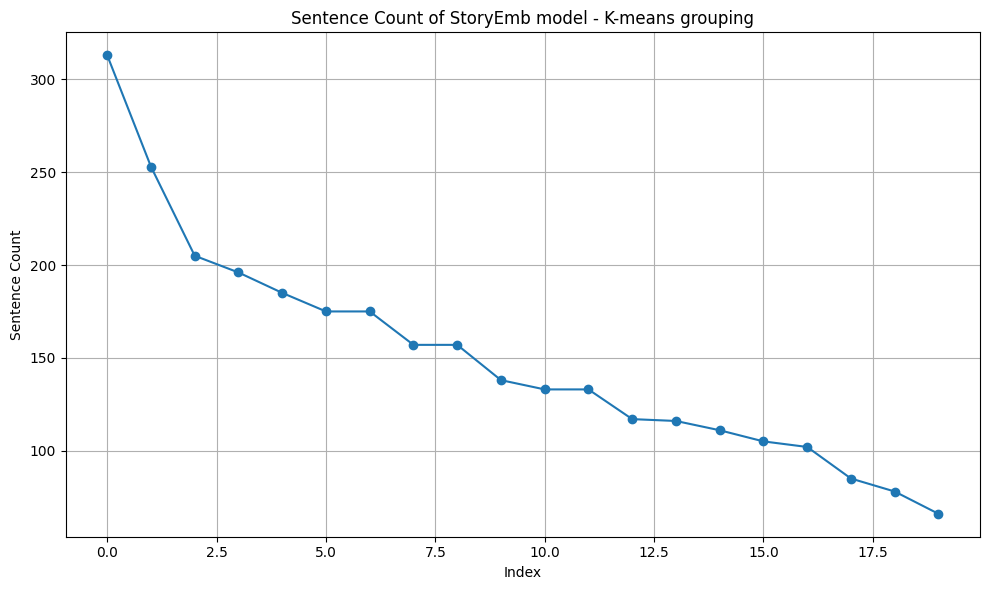

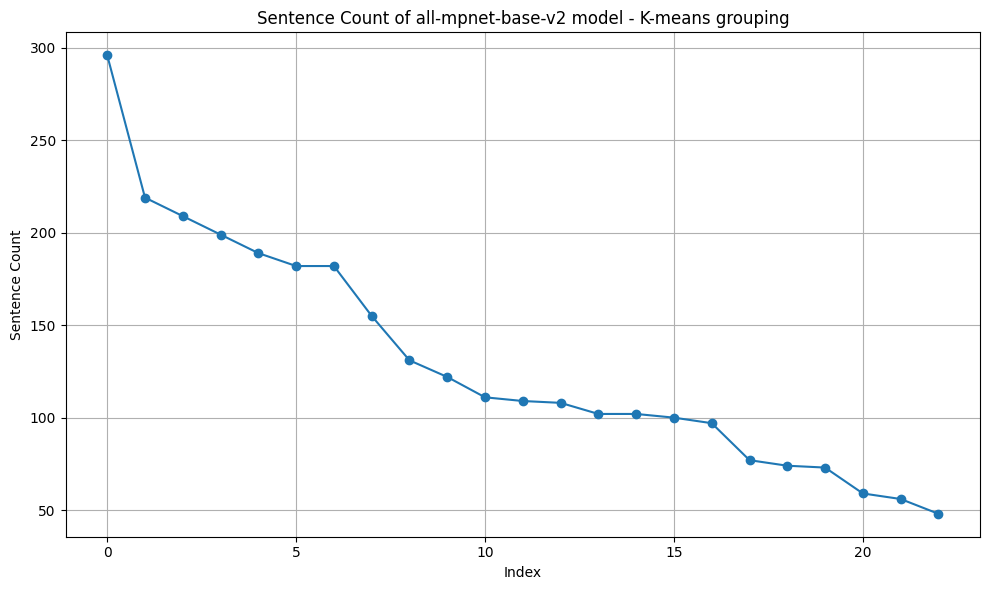

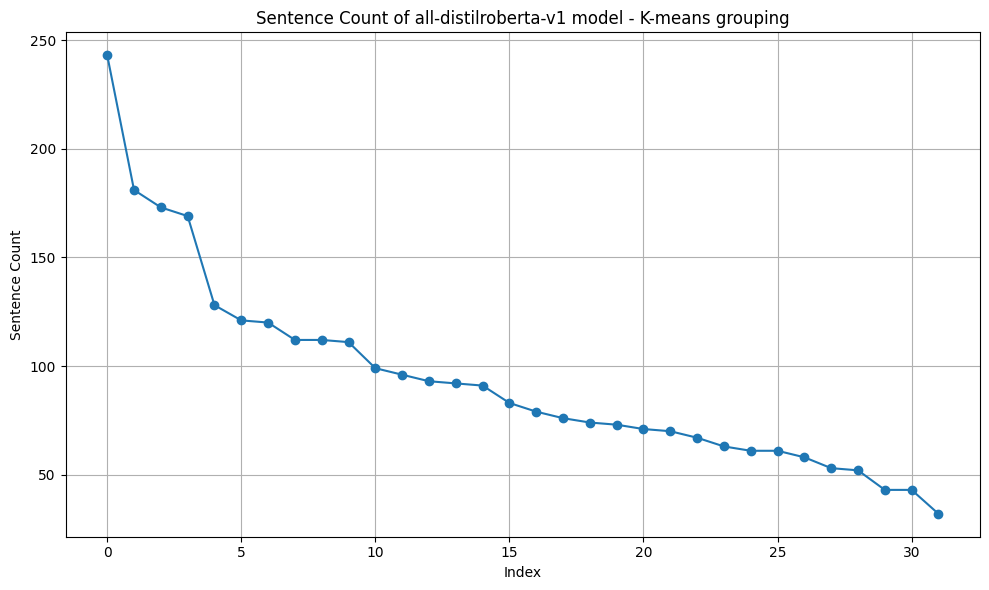

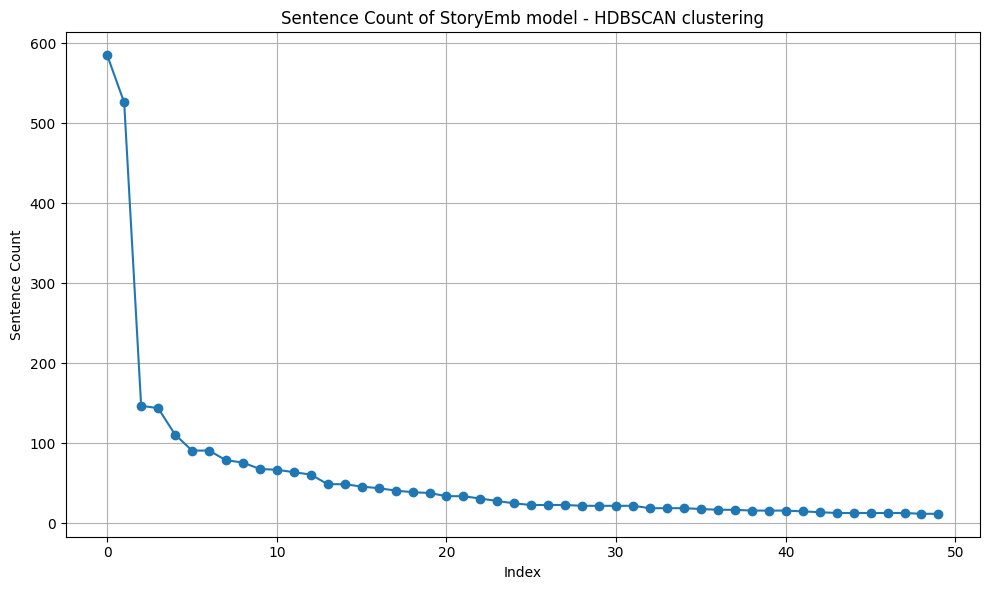

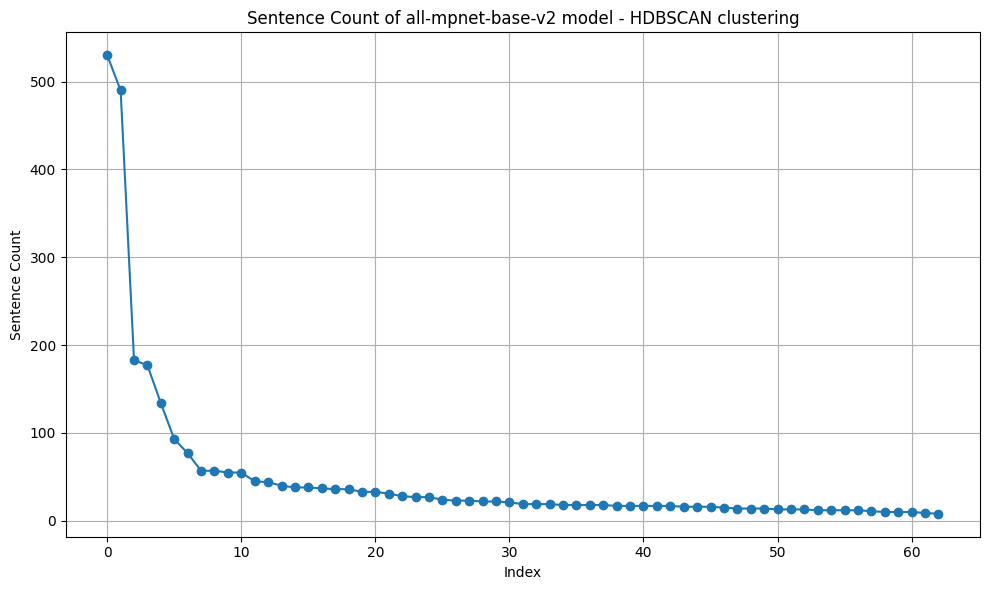

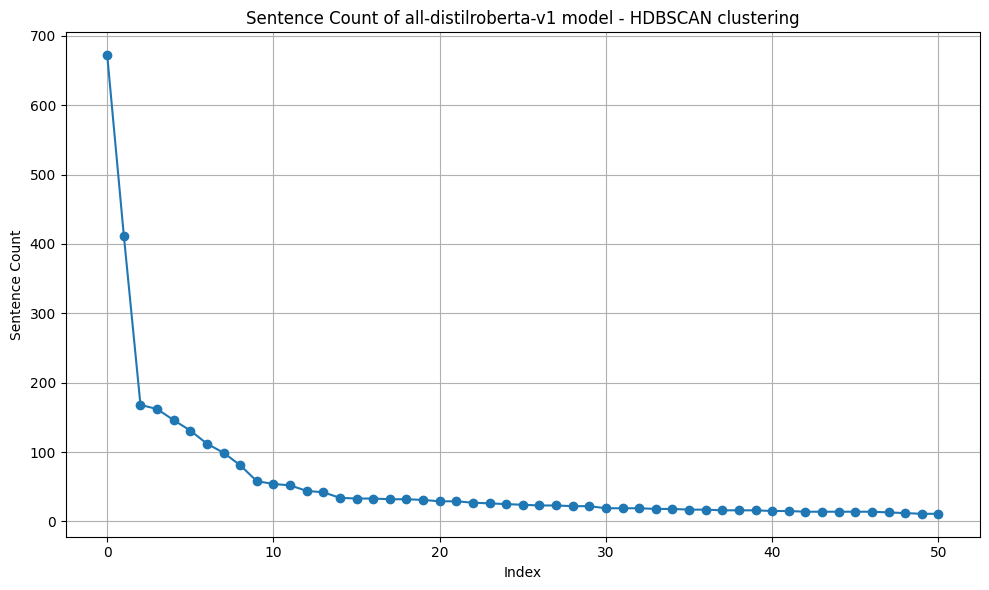

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Create list of vectors and their names
vectors = [
    (vector_sent_kmeans1, "Sentence Count of StoryEmb model - K-means grouping"),
    (vector_sent_kmeans2, "Sentence Count of all-mpnet-base-v2 model - K-means grouping"),
    (vector_sent_kmeans3, "Sentence Count of all-distilroberta-v1 model - K-means grouping"),
    (vector_sent_hdbscan1, "Sentence Count of StoryEmb model - HDBSCAN clustering"),
    (vector_sent_hdbscan2, "Sentence Count of all-mpnet-base-v2 model - HDBSCAN clustering"),
    (vector_sent_hdbscan3, "Sentence Count of all-distilroberta-v1 model - HDBSCAN clustering")
]

# Create the output directory if it doesn't exist
output_dir = '/content/images/'
os.makedirs(output_dir, exist_ok=True)

# Loop through each vector and create its plot
for vector, title in vectors:
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(vector)), vector, marker='o')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Sentence Count')
    plt.grid(True)
    plt.tight_layout()

    # Create safe filename
    filename = re.sub(r'[^a-zA-Z0-9_\\-]', '_', title) + ".png"
    save_path = os.path.join(output_dir, filename)

    # Save plot
    plt.savefig(save_path)
    plt.show()


## Log Log plot - linear regression
- check for power law distribution


In [ ]:
#Linear regression
from scipy.stats import linregress

def linear_regression(counts):
    """Perform linear regression on log-transformed data."""
    # Log transform the data
    x = np.log10(np.arange(1, len(counts)+1))
    y = np.log10(counts)

    # Linear regression
    slope, intercept, r_val, p_val, std_err = linregress(x, y)

    # Regression prediction
    y_pred = slope * x + intercept

    return x, y, slope, intercept, r_val, p_val, y_pred

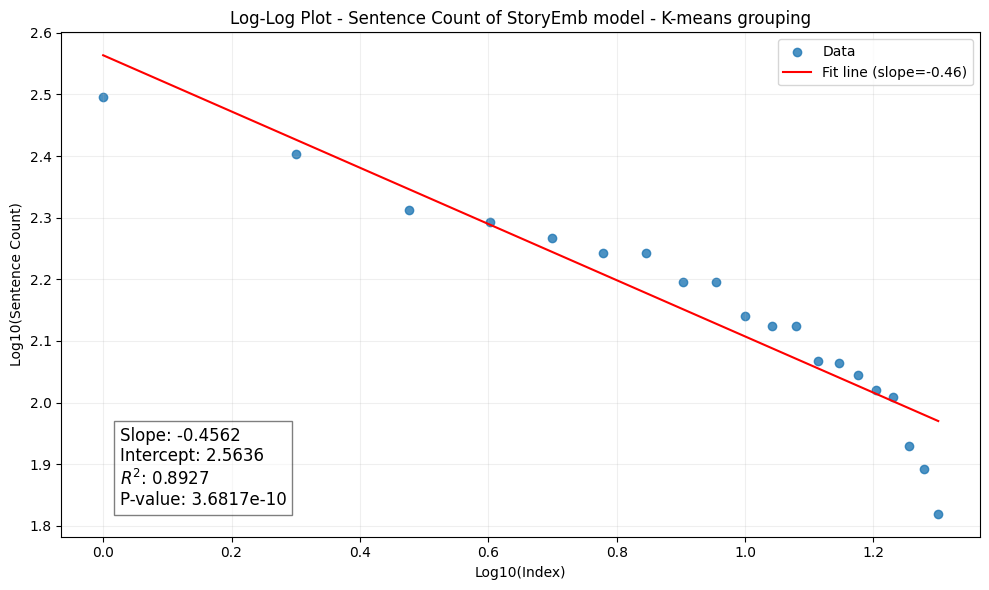


Regression Results for Sentence Count of StoryEmb model - K-means grouping:
   - Slope: -0.4562
   - Intercept: 2.5636
   - R-squared: 0.8927
   - P-value: 3.6817e-10


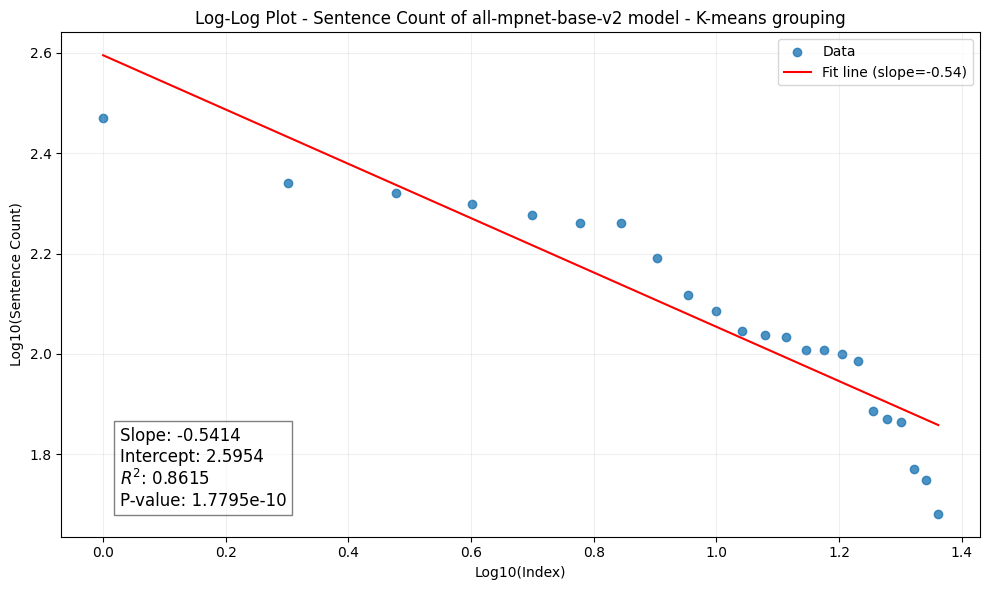


Regression Results for Sentence Count of all-mpnet-base-v2 model - K-means grouping:
   - Slope: -0.5414
   - Intercept: 2.5954
   - R-squared: 0.8615
   - P-value: 1.7795e-10


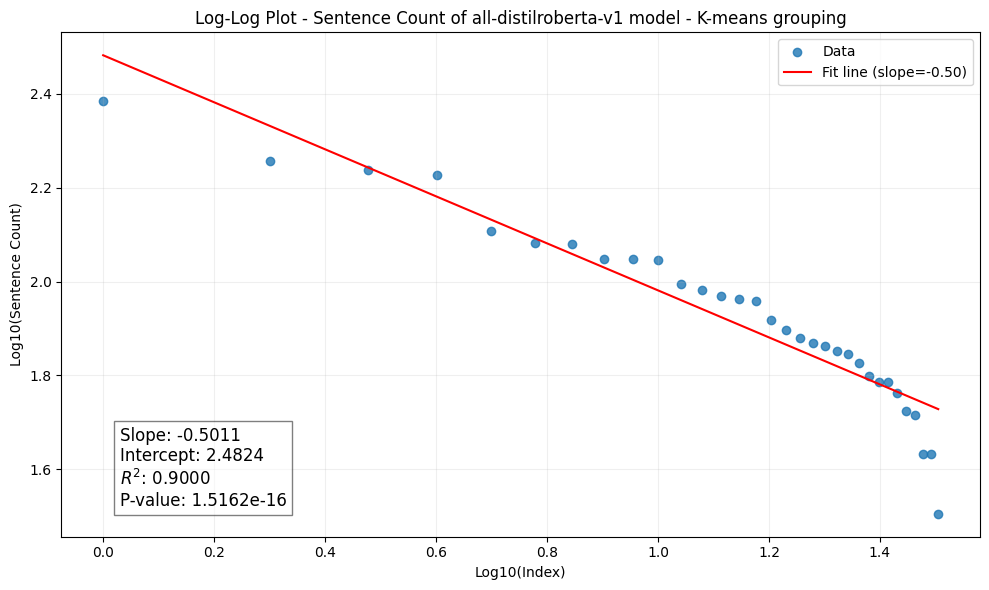


Regression Results for Sentence Count of all-distilroberta-v1 model - K-means grouping:
   - Slope: -0.5011
   - Intercept: 2.4824
   - R-squared: 0.9000
   - P-value: 1.5162e-16


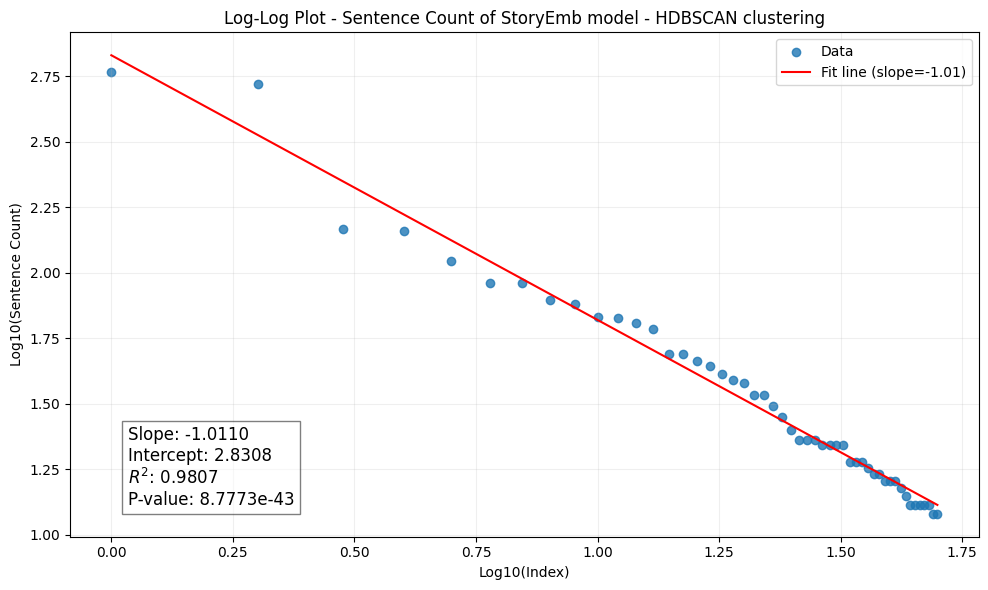


Regression Results for Sentence Count of StoryEmb model - HDBSCAN clustering:
   - Slope: -1.0110
   - Intercept: 2.8308
   - R-squared: 0.9807
   - P-value: 8.7773e-43


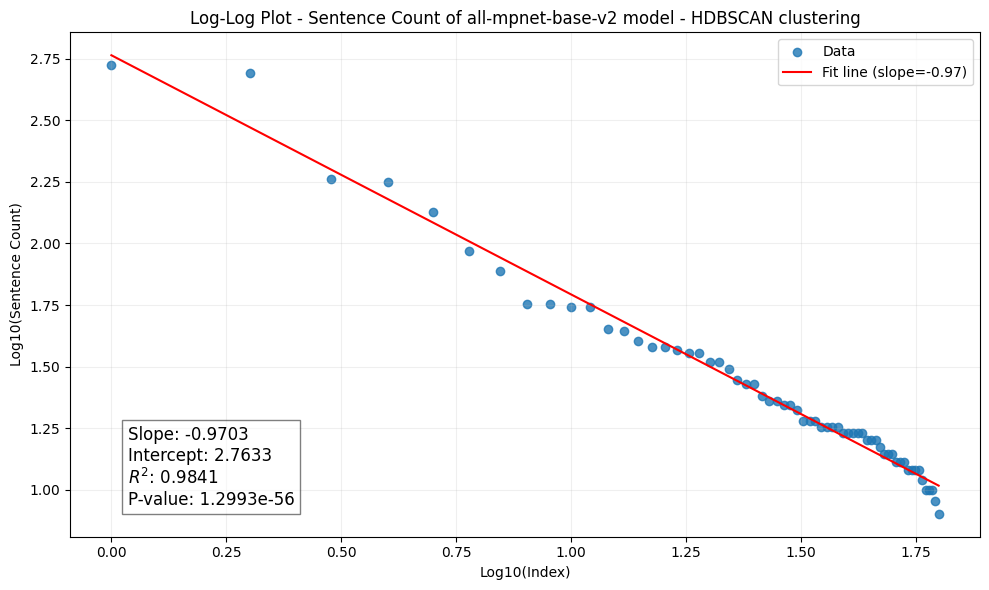


Regression Results for Sentence Count of all-mpnet-base-v2 model - HDBSCAN clustering:
   - Slope: -0.9703
   - Intercept: 2.7633
   - R-squared: 0.9841
   - P-value: 1.2993e-56


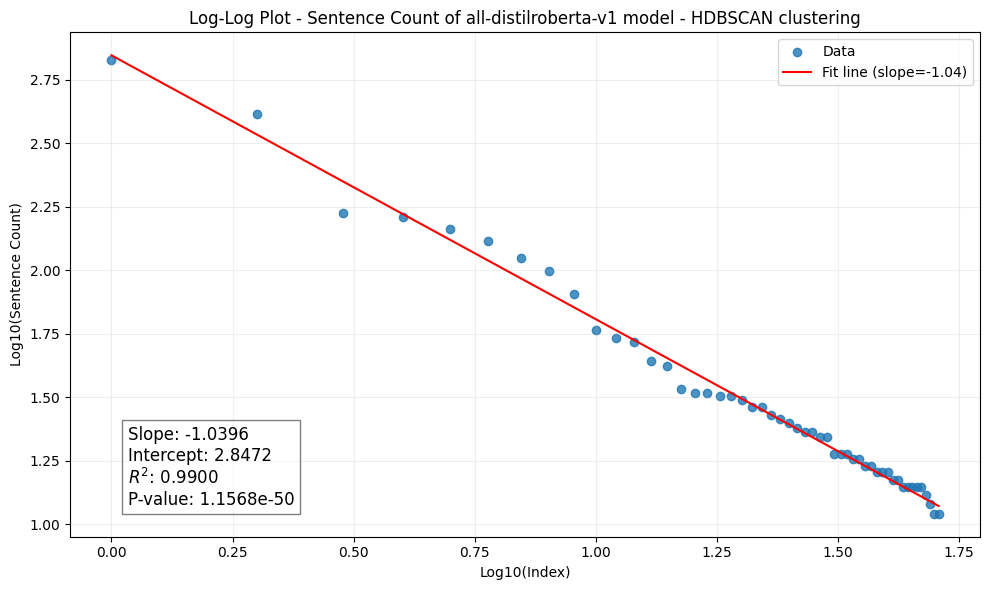


Regression Results for Sentence Count of all-distilroberta-v1 model - HDBSCAN clustering:
   - Slope: -1.0396
   - Intercept: 2.8472
   - R-squared: 0.9900
   - P-value: 1.1568e-50


In [ ]:
# Create the output directory if it doesn't exist
output_dir = '/content/images/'
os.makedirs(output_dir, exist_ok=True)

# Loop through each vector
for vector, title in vectors:
    # Perform linear regression
    x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(vector)

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.8, label='Data')
    plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')

    # Customize plot
    plt.title(f"Log-Log Plot - {title}")
    plt.xlabel('Log10(Index)')
    plt.ylabel('Log10(Sentence Count)')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()

    # Add regression statistics box
    text_x = min(x) + (max(x) - min(x)) * 0.02
    text_y = min(y) + (max(y) - min(y)) * 0.02
    plt.text(text_x, text_y,
             f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()

    # Create a safe filename and save
    filename = re.sub(r'[^a-zA-Z0-9_\\-]', '_', title) + '_loglog.png'
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path)
    plt.show()

    # Print regression statistics
    print(f"\nRegression Results for {title}:")
    print(f"   - Slope: {slope:.4f}")
    print(f"   - Intercept: {intercept:.4f}")
    print(f"   - R-squared: {r_val**2:.4f}")
    print(f"   - P-value: {p_val:.4e}")